# 🎯 Compute Optimal Restoration Parameters

**Goal**: For each damaged/undamaged image pair, find the optimal color correction and sharpening parameters that maximize similarity.

**What we'll do**:
1. Load paired dataset (damaged + undamaged)
2. For each pair, test different restoration parameter combinations
3. Measure similarity using PSNR and SSIM
4. Record optimal parameters that give highest similarity
5. Create training dataset: [14 FFT features] → [optimal parameters]

**Output**: CSV with features + optimal restoration parameters for regression training

---

## 📦 Step 1: Import Libraries

In [9]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from concurrent.futures import ProcessPoolExecutor
import multiprocessing

# Import our modules
import sys
sys.path.append('../')
from src.basics.optimized_restoration import restore_image_optimized
from src.ml.feature_extractor import extract_ml_features

print('✅ All libraries imported successfully!')
print(f'🚀 Parallel processing available: {multiprocessing.cpu_count()} CPU cores')

✅ All libraries imported successfully!
🚀 Parallel processing available: 20 CPU cores


## 📂 Step 2: Load Paired Dataset

In [10]:
# Paths to damaged and undamaged images
damaged_dir = '../data/raw/AI_for_Art_Restoration_2/paired_dataset_art/damaged'
undamaged_dir = '../data/raw/AI_for_Art_Restoration_2/paired_dataset_art/undamaged'

# Get list of image pairs
damaged_files = sorted([f for f in os.listdir(damaged_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
undamaged_files = sorted([f for f in os.listdir(undamaged_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

# Find matching pairs
paired_files = [f for f in damaged_files if f in undamaged_files]

print(f'📊 Dataset Statistics:')
print('='*70)
print(f'Damaged images found: {len(damaged_files)}')
print(f'Undamaged images found: {len(undamaged_files)}')
print(f'Matching pairs: {len(paired_files)}')
print()
print(f'First 5 pairs: {paired_files[:5]}')

📊 Dataset Statistics:
Damaged images found: 114
Undamaged images found: 114
Matching pairs: 112

First 5 pairs: ['1.png', '10.png', '100.png', '101.jpg', '102.jpg']


## 🔍 Step 3: Define Parameter Search Space

We'll test different combinations of restoration parameters to find what works best for each image.

In [11]:
# Parameter ranges to test
# We'll test a grid of parameters and find the best combination

COLOR_METHODS = ['white_balance', 'none']  # none means skip color correction
SHARPEN_SIGMA = [0.5, 1.0, 1.5, 2.0]  # Gaussian blur sigma
SHARPEN_STRENGTH = [0.5, 1.0, 1.5, 2.0, 2.5]  # Sharpening intensity

print('🎯 Parameter Search Space:')
print('='*70)
print(f'Color correction methods: {COLOR_METHODS}')
print(f'Sharpening sigma values: {SHARPEN_SIGMA}')
print(f'Sharpening strength values: {SHARPEN_STRENGTH}')
print()
total_combinations = len(COLOR_METHODS) * len(SHARPEN_SIGMA) * len(SHARPEN_STRENGTH)
print(f'Total parameter combinations to test: {total_combinations}')
print(f'Total evaluations: {len(paired_files) * total_combinations}')

🎯 Parameter Search Space:
Color correction methods: ['white_balance', 'none']
Sharpening sigma values: [0.5, 1.0, 1.5, 2.0]
Sharpening strength values: [0.5, 1.0, 1.5, 2.0, 2.5]

Total parameter combinations to test: 40
Total evaluations: 4480


## 🧪 Step 4: Find Optimal Parameters for Each Image Pair

For each damaged image:
1. Try all parameter combinations
2. Apply restoration
3. Compare with ground truth (undamaged image)
4. Record parameters that give highest PSNR + SSIM

In [12]:
def compute_similarity_score(restored, undamaged):
    """
    Compute combined similarity score using PSNR and SSIM.
    
    Args:
        restored: Restored image
        undamaged: Ground truth undamaged image
    
    Returns:
        score: Combined score (higher is better)
        psnr_val: PSNR value
        ssim_val: SSIM value
    """
    # Resize images to same size if needed
    if restored.shape != undamaged.shape:
        restored = cv2.resize(restored, (undamaged.shape[1], undamaged.shape[0]))
    
    # Calculate PSNR (higher is better, typically 20-50 dB)
    psnr_val = psnr(undamaged, restored)
    
    # Calculate SSIM (higher is better, 0-1 range)
    # For color images, compute SSIM per channel and average
    if len(restored.shape) == 3:
        ssim_val = ssim(undamaged, restored, channel_axis=2, data_range=255)
    else:
        ssim_val = ssim(undamaged, restored, data_range=255)
    
    # Combined score: normalize PSNR (divide by 50) and weight both metrics equally
    # This gives a score roughly in 0-1 range
    combined_score = 0.5 * (psnr_val / 50.0) + 0.5 * ssim_val
    
    return combined_score, psnr_val, ssim_val

print('✅ Similarity function defined!')

✅ Similarity function defined!


In [13]:
def find_optimal_parameters(damaged_path, undamaged_path):
    """
    Find optimal restoration parameters for a damaged/undamaged image pair.
    
    Args:
        damaged_path: Path to damaged image
        undamaged_path: Path to undamaged image
    
    Returns:
        best_params: Dictionary with optimal parameters
        best_score: Best similarity score achieved
        best_psnr: PSNR at best parameters
        best_ssim: SSIM at best parameters
    """
    # Load images
    damaged = cv2.imread(damaged_path)
    undamaged = cv2.imread(undamaged_path)
    
    if damaged is None or undamaged is None:
        return None, 0, 0, 0
    
    best_score = -1
    best_params = {}
    best_psnr = 0
    best_ssim = 0
    
    # Test all parameter combinations
    for color_method in COLOR_METHODS:
        for sigma in SHARPEN_SIGMA:
            for strength in SHARPEN_STRENGTH:
                try:
                    # Apply restoration with these parameters
                    if color_method == 'none':
                        # Only sharpening, no color correction
                        from src.basics.advanced_restoration import unsharp_mask
                        restored = unsharp_mask(damaged.copy(), sigma=sigma, strength=strength)
                    else:
                        restored = restore_image_optimized(
                            damaged.copy(),
                            color_method=color_method,
                            sharpen_sigma=sigma,
                            sharpen_strength=strength
                        )
                    
                    # Compute similarity with ground truth
                    score, psnr_val, ssim_val = compute_similarity_score(restored, undamaged)
                    
                    # Update best parameters if this is better
                    if score > best_score:
                        best_score = score
                        best_psnr = psnr_val
                        best_ssim = ssim_val
                        best_params = {
                            'color_method': color_method,
                            'apply_color_correction': 1 if color_method != 'none' else 0,
                            'sharpen_sigma': sigma,
                            'sharpen_strength': strength
                        }
                
                except Exception as e:
                    continue
    
    return best_params, best_score, best_psnr, best_ssim

print('✅ Parameter optimization function defined!')

✅ Parameter optimization function defined!


In [14]:
# Worker function for parallel processing
def process_single_image_pair(args):
    """
    Process a single damaged/undamaged image pair.
    This function is designed to work with multiprocessing.
    
    Args:
        args: Tuple of (filename, damaged_dir, undamaged_dir)
    
    Returns:
        dict: Result containing features and optimal parameters, or None if failed
    """
    filename, damaged_dir, undamaged_dir = args
    damaged_path = os.path.join(damaged_dir, filename)
    undamaged_path = os.path.join(undamaged_dir, filename)
    
    try:
        # Find optimal parameters
        best_params, score, psnr_val, ssim_val = find_optimal_parameters(damaged_path, undamaged_path)
        
        if best_params:
            # Extract features from damaged image
            features, feature_names = extract_ml_features(damaged_path)
            
            # Combine features and optimal parameters
            result = {
                'filename': filename,
                'similarity_score': score,
                'psnr': psnr_val,
                'ssim': ssim_val,
            }
            
            # Add features
            for name, value in zip(feature_names, features):
                result[name] = value
            
            # Add optimal parameters
            result.update(best_params)
            
            return result
        else:
            return None
    
    except Exception as e:
        print(f'⚠️ Error processing {filename}: {e}')
        return None

print('✅ Parallel processing worker function defined!')

✅ Parallel processing worker function defined!


In [16]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

print('🔄 Processing ALL image pairs to find optimal parameters...')
print('='*70)
print(f'📊 Total images to process: {len(paired_files)}')
print(f'🚀 Using parallel processing with {multiprocessing.cpu_count()} CPU cores')
print()

# Prepare arguments for parallel processing
args_list = [(filename, damaged_dir, undamaged_dir) for filename in paired_files]

# Use ThreadPoolExecutor instead of ProcessPoolExecutor
results = []
with ThreadPoolExecutor(max_workers=4) as executor:
    # Submit all tasks
    futures = [executor.submit(process_single_image_pair, args) for args in args_list]
    
    # Collect results with progress bar
    for future in tqdm(futures, desc='Optimizing parameters', total=len(futures)):
        result = future.result()
        if result is not None:
            results.append(result)

print()
print(f'✅ Processed {len(results)}/{len(paired_files)} image pairs successfully!')
print(f'📈 Success rate: {len(results)/len(paired_files)*100:.1f}%')

🔄 Processing ALL image pairs to find optimal parameters...
📊 Total images to process: 112
🚀 Using parallel processing with 20 CPU cores



Optimizing parameters: 100%|██████████| 112/112 [06:15<00:00,  3.35s/it]  


✅ Processed 112/112 image pairs successfully!
📈 Success rate: 100.0%


## 📊 Step 5: Analyze Optimal Parameters

In [17]:
# Convert to DataFrame
df_optimal = pd.DataFrame(results)

print('📊 Optimal Parameters Dataset:')
print('='*70)
print(f'Total samples: {len(df_optimal)}')
print(f'Columns: {len(df_optimal.columns)}')
print()
print('Sample data:')
df_optimal.head()

📊 Optimal Parameters Dataset:
Total samples: 112
Columns: 22

Sample data:


,filename,similarity_score,psnr,ssim,mean,std_dev,skewness,kurtosis,low_freq_energy,high_freq_energy,...,radial_25,radial_50,radial_75,radial_edge,color_balance_need,sharpening_need,color_method,apply_color_correction,sharpen_sigma,sharpen_strength
0,1.png,0.440439,14.960686,0.581664,172.078791,24.651689,0.419049,0.405692,282.272820,172.033401,...,214.490409,198.176288,178.011499,163.603976,0.077168,0.405136,white_balance,1,0.5,0.5
1,10.png,0.196737,10.721449,0.179045,170.703457,18.225493,0.014498,1.529401,219.883419,170.090076,...,194.418368,178.976622,173.541926,166.637158,0.077604,0.000000,white_balance,1,0.5,0.5
2,100.png,0.323986,16.013380,0.327703,144.019931,21.890683,0.278796,1.180011,187.940305,142.386107,...,174.719671,160.692192,151.347043,138.558214,0.412804,0.000000,none,0,0.5,0.5
3,101.jpg,0.362836,14.268128,0.440310,135.630466,26.014150,0.708370,0.983259,208.361504,134.742889,...,177.165557,160.283772,140.546631,127.639632,0.124929,0.000000,none,0,0.5,0.5
4,102.jpg,0.208541,9.109903,0.234884,147.370054,26.402196,0.469758,0.694385,220.423909,146.272710,...,194.342055,169.853374,150.250020,137.117490,0.067642,0.178267,white_balance,1,0.5,0.5


In [18]:
# Statistical summary of optimal parameters
print('📈 Statistical Summary of Optimal Parameters:')
print('='*70)
print()
print('Similarity Metrics:')
print(df_optimal[['similarity_score', 'psnr', 'ssim']].describe())
print()
print('Optimal Restoration Parameters:')
print(df_optimal[['apply_color_correction', 'sharpen_sigma', 'sharpen_strength']].describe())

📈 Statistical Summary of Optimal Parameters:

Similarity Metrics:
       similarity_score        psnr        ssim
count        112.000000  112.000000  112.000000
mean           0.345245   14.902440    0.392441
std            0.089381    2.786763    0.137716
min            0.153839    8.602660    0.083926
25%            0.282442   13.305065    0.296440
50%            0.353156   14.721708    0.405610
75%            0.407968   16.587940    0.499285
max            0.559652   22.187165    0.686432

Optimal Restoration Parameters:
       apply_color_correction  sharpen_sigma  sharpen_strength
count              112.000000          112.0             112.0
mean                 0.142857            0.5               0.5
std                  0.351500            0.0               0.0
min                  0.000000            0.5               0.5
25%                  0.000000            0.5               0.5
50%                  0.000000            0.5               0.5
75%                  0.00000

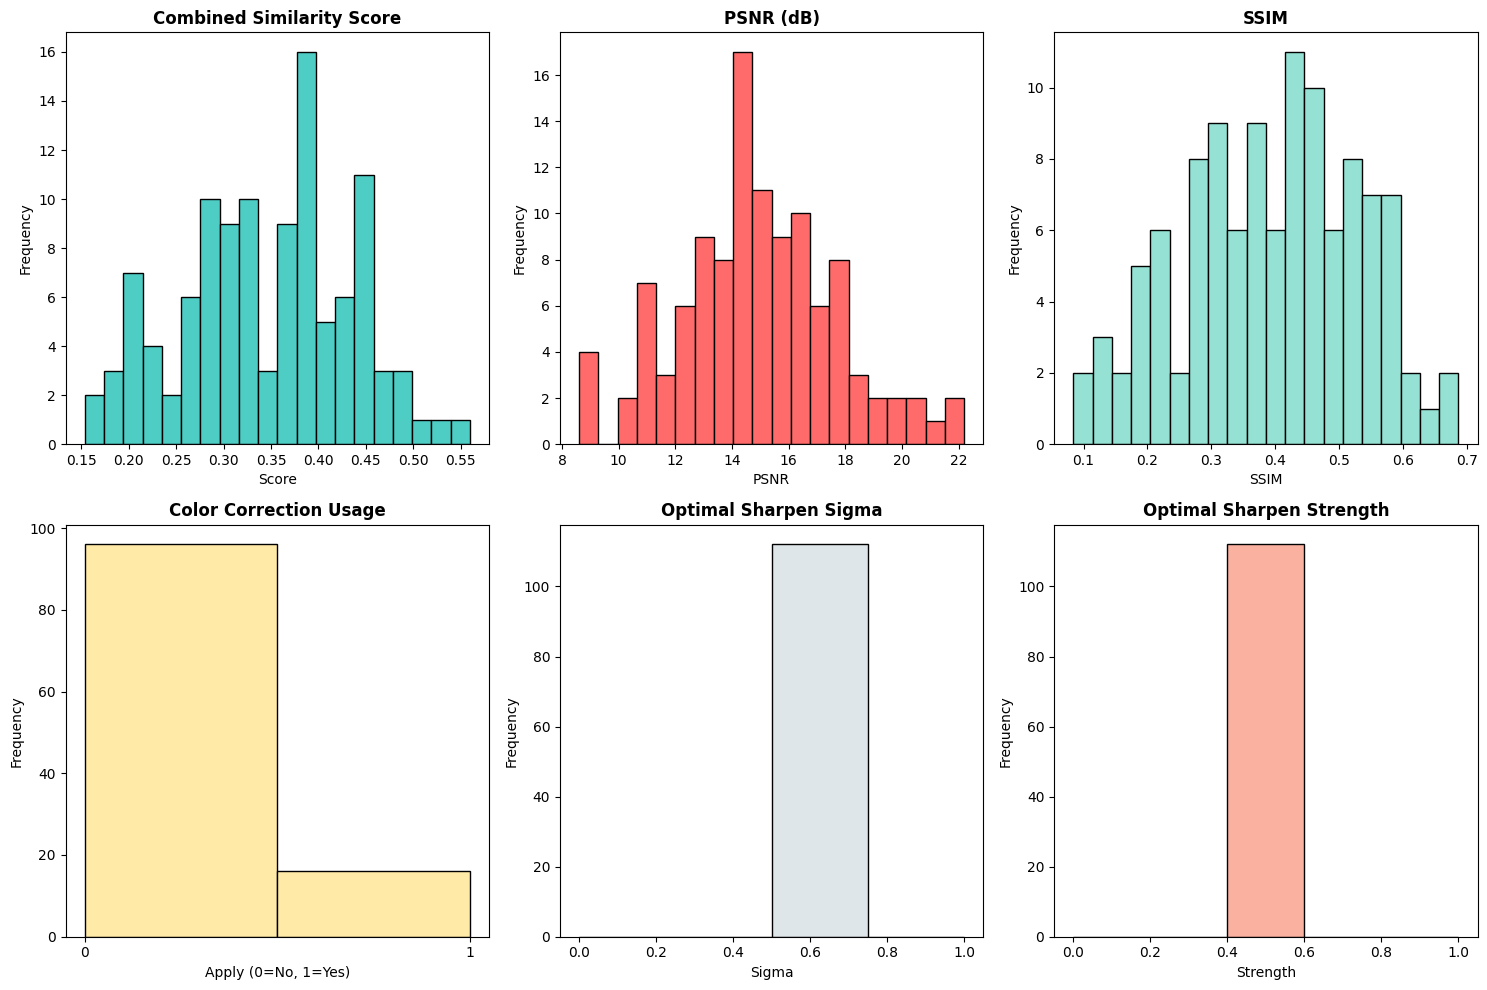

✅ Parameter distribution analysis complete!


In [19]:
# Visualize parameter distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Similarity metrics
axes[0, 0].hist(df_optimal['similarity_score'], bins=20, color='#4ecdc4', edgecolor='black')
axes[0, 0].set_title('Combined Similarity Score', fontweight='bold')
axes[0, 0].set_xlabel('Score')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(df_optimal['psnr'], bins=20, color='#ff6b6b', edgecolor='black')
axes[0, 1].set_title('PSNR (dB)', fontweight='bold')
axes[0, 1].set_xlabel('PSNR')
axes[0, 1].set_ylabel('Frequency')

axes[0, 2].hist(df_optimal['ssim'], bins=20, color='#95e1d3', edgecolor='black')
axes[0, 2].set_title('SSIM', fontweight='bold')
axes[0, 2].set_xlabel('SSIM')
axes[0, 2].set_ylabel('Frequency')

# Optimal parameters
axes[1, 0].hist(df_optimal['apply_color_correction'], bins=2, color='#ffeaa7', edgecolor='black')
axes[1, 0].set_title('Color Correction Usage', fontweight='bold')
axes[1, 0].set_xlabel('Apply (0=No, 1=Yes)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xticks([0, 1])

axes[1, 1].hist(df_optimal['sharpen_sigma'], bins=len(SHARPEN_SIGMA), color='#dfe6e9', edgecolor='black')
axes[1, 1].set_title('Optimal Sharpen Sigma', fontweight='bold')
axes[1, 1].set_xlabel('Sigma')
axes[1, 1].set_ylabel('Frequency')

axes[1, 2].hist(df_optimal['sharpen_strength'], bins=len(SHARPEN_STRENGTH), color='#fab1a0', edgecolor='black')
axes[1, 2].set_title('Optimal Sharpen Strength', fontweight='bold')
axes[1, 2].set_xlabel('Strength')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print('✅ Parameter distribution analysis complete!')

In [20]:
# Analyze most common optimal settings
print('🎯 Most Common Optimal Settings:')
print('='*70)
print()
print(f"Color correction used: {df_optimal['apply_color_correction'].sum()} / {len(df_optimal)} images ({df_optimal['apply_color_correction'].sum()/len(df_optimal)*100:.1f}%)")
print()
print('Most common sharpen_sigma values:')
print(df_optimal['sharpen_sigma'].value_counts().head())
print()
print('Most common sharpen_strength values:')
print(df_optimal['sharpen_strength'].value_counts().head())
print()
print('Average PSNR improvement:', df_optimal['psnr'].mean(), 'dB')
print('Average SSIM improvement:', df_optimal['ssim'].mean())

🎯 Most Common Optimal Settings:

Color correction used: 16 / 112 images (14.3%)

Most common sharpen_sigma values:
sharpen_sigma
0.5    112
Name: count, dtype: int64

Most common sharpen_strength values:
sharpen_strength
0.5    112
Name: count, dtype: int64

Average PSNR improvement: 14.902440164223075 dB
Average SSIM improvement: 0.392441252601665


## 💾 Step 6: Save Training Dataset

In [23]:
# Save to CSV for regression training
output_path = '../data/processed/regression_training_data.csv'
df_optimal.to_csv(output_path, index=False)

# Get feature names from one sample to print stats correctly
_, feature_names = extract_ml_features(os.path.join(damaged_dir, paired_files[0]))

print('💾 Training Dataset Saved!')
print('='*70)
print(f'File: {output_path}')
print(f'Samples: {len(df_optimal)}')
print(f'Features: {len([col for col in df_optimal.columns if col in feature_names])}')
print(f'Target variables: apply_color_correction, sharpen_sigma, sharpen_strength')
print()
print('✅ Ready for regression model training!')

💾 Training Dataset Saved!
File: ../data/processed/regression_training_data.csv
Samples: 112
Features: 14
Target variables: apply_color_correction, sharpen_sigma, sharpen_strength

✅ Ready for regression model training!


## 🎨 Step 7: Visualize Sample Results

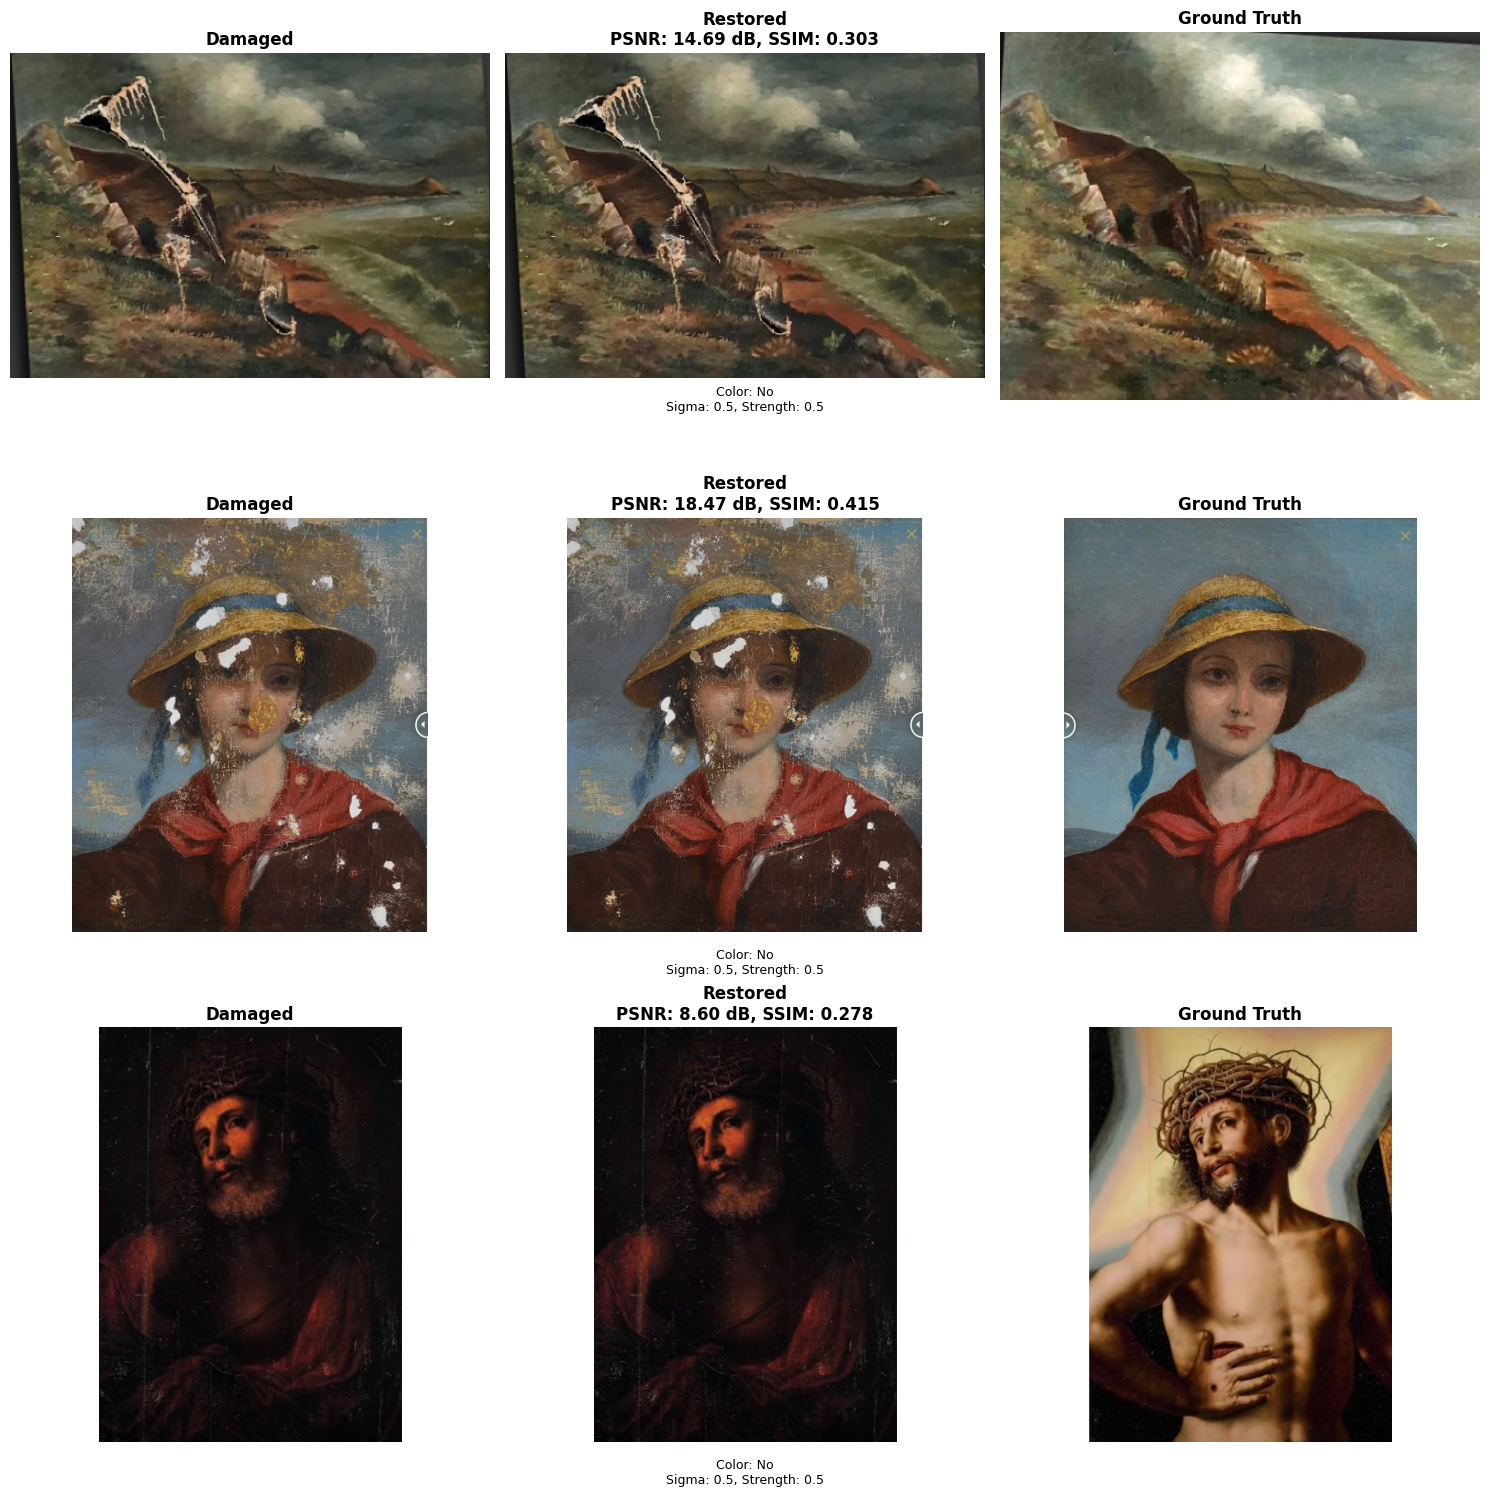

✅ Visual comparison complete!


In [24]:
# Show before/after examples with optimal parameters
n_examples = 3
sample_results = df_optimal.sample(min(n_examples, len(df_optimal)))

fig, axes = plt.subplots(n_examples, 3, figsize=(15, 5*n_examples))
if n_examples == 1:
    axes = axes.reshape(1, -1)

for idx, (_, row) in enumerate(sample_results.iterrows()):
    filename = row['filename']
    
    # Load images
    damaged_path = os.path.join(damaged_dir, filename)
    undamaged_path = os.path.join(undamaged_dir, filename)
    
    damaged = cv2.imread(damaged_path)
    undamaged = cv2.imread(undamaged_path)
    
    # Apply optimal restoration
    if row['apply_color_correction'] == 1:
        restored = restore_image_optimized(
            damaged.copy(),
            color_method=row['color_method'],
            sharpen_sigma=row['sharpen_sigma'],
            sharpen_strength=row['sharpen_strength']
        )
    else:
        from src.basics.advanced_restoration import unsharp_mask
        restored = unsharp_mask(
            damaged.copy(),
            sigma=row['sharpen_sigma'],
            strength=row['sharpen_strength']
        )
    
    # Convert BGR to RGB for display
    damaged = cv2.cvtColor(damaged, cv2.COLOR_BGR2RGB)
    restored = cv2.cvtColor(restored, cv2.COLOR_BGR2RGB)
    undamaged = cv2.cvtColor(undamaged, cv2.COLOR_BGR2RGB)
    
    # Display
    axes[idx, 0].imshow(damaged)
    axes[idx, 0].set_title('Damaged', fontweight='bold')
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(restored)
    axes[idx, 1].set_title(f'Restored\nPSNR: {row["psnr"]:.2f} dB, SSIM: {row["ssim"]:.3f}', fontweight='bold')
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(undamaged)
    axes[idx, 2].set_title('Ground Truth', fontweight='bold')
    axes[idx, 2].axis('off')
    
    # Add parameter info
    param_text = f"Color: {'Yes' if row['apply_color_correction'] == 1 else 'No'}\n"
    param_text += f"Sigma: {row['sharpen_sigma']}, Strength: {row['sharpen_strength']}"
    axes[idx, 1].text(0.5, -0.1, param_text, ha='center', transform=axes[idx, 1].transAxes, fontsize=9)

plt.tight_layout()
plt.show()

print('✅ Visual comparison complete!')

## 🎉 Summary

### ✅ What We Accomplished:
1. Loaded paired damaged/undamaged images
2. Tested multiple restoration parameter combinations
3. Found optimal parameters that maximize similarity to ground truth
4. Extracted FFT features from damaged images
5. Created training dataset: **[14 features] → [optimal parameters]**

### 📊 Dataset Created:
- **Input**: 14 FFT features (damage characteristics)
- **Output**: 3 optimal parameters (apply_color_correction, sharpen_sigma, sharpen_strength)
- **Quality**: Measured by PSNR and SSIM against ground truth

### 🚀 Next Steps:
1. **Train regression model** in next notebook (`4_train_regression_model.ipynb`)
2. **Use cross-validation** to ensure model generalizes well
3. **Test on new images** and validate restoration quality
4. **Deploy smart restoration** system

### 💡 Key Insights:
- We now have **optimal restoration recipes** for each image
- Model will learn to predict these recipes from damage features
- This ensures we **never over-restore** (trained on what actually works!)

**Ready to train the regression model!** 🤖✨